In [1]:
from Chain_Class import Chain
from THIS_rungerrychain import *
from Create_Chain import *

from gerrychain import updaters, constraints
from gerrychain.updaters import Tally, cut_edges

import geopandas as gpd
import numpy as np
import pandas as pd

# Chain Class

## Updater Functions

These are updaters that we are manually defining

In [2]:
def split_counter(partition):
    count_splits = 0
    for item in partition["county_info"]:
        count_splits += len(partition["county_info"][item][2]) - 1
    return count_splits

def num_split_counties(partition):
    counties_with_splits = 0
    for item in partition["county_info"]:
        if len(partition["county_info"][item][2]) > 1:
            counties_with_splits += 1
    return counties_with_splits

def oversplit_counties(partition):
    oversplits = 0
    for item in partition["county_info"]:
        if len(partition["county_info"][item][2]) > 2:
            oversplits += 1
    return oversplits

def bad_incumbents(partition):
    num_problems = 0
    for part in partition.parts:
        if partition["incumbents"][part] > 1:
            num_problems += 1
    return num_problems

def subpop_over_threshold(partition):
    count_over = 0
    alpha = 0.5# Arbitrarily defined threshold
    for dist in partition['population']:
        # whatever this first term is needs to be an updater in my updaters so the constraint validator can look for it
        if partition['subpop'][dist] / partition['population'][dist] >= alpha:
            count_over += 1
    return count_over

## Create the Chain

In [3]:
test_chain = Chain(steps=10, pop_deviation=.05)

We need to add our updaters to this chain

In [4]:
test_chain.define_updater(updater_name="split_counter", updater_function=split_counter)
test_chain.define_updater(updater_name="num_split_counties", updater_function=num_split_counties)
test_chain.define_updater(updater_name="oversplit_counties",updater_function=oversplit_counties)
test_chain.define_updater(updater_name="bad_incumbents",updater_function=bad_incumbents)
test_chain.define_updater(updater_name="subpop_over_threshold",updater_function=subpop_over_threshold)

test_chain.define_updater(updater_name="population", updater_function=updaters.Tally("total",alias="population"))
test_chain.define_updater(updater_name='county_info',updater_function=updaters.county_splits("county_info","county"))
test_chain.define_updater("incumbents",updaters.Tally("incumbent",alias='incumbents'))
test_chain.define_updater("subpop",updaters.Tally("blk_1",alias='subpop'))


In [5]:
test_chain.get_updaters()

{'split_counter': <function __main__.split_counter(partition)>,
 'num_split_counties': <function __main__.num_split_counties(partition)>,
 'oversplit_counties': <function __main__.oversplit_counties(partition)>,
 'bad_incumbents': <function __main__.bad_incumbents(partition)>,
 'subpop_over_threshold': <function __main__.subpop_over_threshold(partition)>,
 'population': <gerrychain.updaters.tally.Tally at 0x10cced930>,
 'county_info': <function gerrychain.updaters.county_splits.county_splits.<locals>._get_county_splits(partition)>,
 'incumbents': <gerrychain.updaters.tally.Tally at 0x10cced720>,
 'subpop': <gerrychain.updaters.tally.Tally at 0x10cceca30>}

## Create the initial partition

We need to do this after updaters and before constraints. 
It will help to look at your geodataframe and see what columns you will be using.

In [6]:
import geopandas as gpd

shp_file='/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Data/State Shp Files/AL/Alabama_VTD_District_Intersection.shp'

gpd.read_file(shp_file).head()

,OBJECTID,Join_Count,TARGET_FID,cd_117,VTD,vtd_cd_117,dups,total,one_race,wht_1,...,last,first,middle,race,res_ad_lat,res_ad_lon,incumbent,Shape_Le_1,Shape_Area,geometry
0,1,0,0,01001,01003000001,01003000001_01001,0,357,334,256,...,None,None,None,None,0.0,0.0,0,1.004504,0.024391,"POLYGON ((-87.76515 31.29735, -87.76360 31.297..."
1,2,0,1,01001,01003000002,01003000002_01001,0,251,242,98,...,None,None,None,None,0.0,0.0,0,1.012120,0.022135,"POLYGON ((-87.81299 31.13709, -87.81653 31.131..."
2,3,0,2,01001,01003000003,01003000003_01001,0,558,538,260,...,None,None,None,None,0.0,0.0,0,0.597227,0.010159,"POLYGON ((-87.90042 30.93770, -87.90144 30.937..."
3,4,0,3,01001,01003000004,01003000004_01001,0,1175,1119,821,...,None,None,None,None,0.0,0.0,0,0.641053,0.012414,"POLYGON ((-87.92361 30.93146, -87.92348 30.931..."
4,5,0,4,01001,01003000005,01003000005_01001,0,1632,1578,401,...,None,None,None,None,0.0,0.0,0,0.188839,0.000877,"POLYGON ((-87.77521 30.83709, -87.77556 30.837..."


In [7]:
test_chain.create_initial_partition(shp_file=shp_file,grouping_assignment_column='cd_117')

/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column last!
  warnings.wa

## Define Constraints

In [8]:
## manually defined constraints

pop_constraint = constraints.within_percent_of_ideal_population(test_chain.get_current_partition(), test_chain.pop_deviation)

county_limit = constraints.UpperBound(
    lambda p: split_counter(p),
    3*split_counter(test_chain.get_current_partition()))

In [9]:
test_chain.define_constraint(constraints.contiguous)
test_chain.define_constraint(pop_constraint)
test_chain.define_constraint(county_limit)

In [10]:
test_chain.constraints

[<function gerrychain.constraints.contiguity.contiguous(partition)>,
 <UpperBound(<lambda> >= 18)>]

## Run a short chain

In [11]:
RunGerryChain(chain_obj=test_chain,seed=0,geographic_area_column='VTD',population_column='total', output_path='/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/test_output',show_progress=True)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10

Chain complete. Time elapsed: 1.5056958198547363 seconds.


# Create Chain Function

In [54]:
updaters_list=[split_counter, num_split_counties, oversplit_counties, bad_incumbents, subpop_over_threshold]

test_chain_2 = CreateChain(steps=10,shp_file=shp_file,grouping_assignment_column='cd_117',updaters=updaters_list)

creating chain object..
defining updaters...
creating partition


/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


defining constraints
chain object created


/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column last!
  warnings.warn("NA values found in column {}!".format(column))
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column first!
  warnings.warn("NA values found in column {}!".format(column))
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column middle!
  warnings.warn("NA values found in column {}!".format(column))
/Users/rebeccawagner/opt/ana

In [53]:
test_chain_2.get_updaters()

{'split_counter': <function __main__.split_counter(partition)>,
 'num_split_counties': <function __main__.num_split_counties(partition)>,
 'oversplit_counties': <function __main__.oversplit_counties(partition)>,
 'bad_incumbents': <function __main__.bad_incumbents(partition)>,
 'subpop_over_threshold': <function __main__.subpop_over_threshold(partition)>,
 'population': <gerrychain.updaters.tally.Tally at 0x16f786e30>,
 'county_info': <function gerrychain.updaters.county_splits.county_splits.<locals>._get_county_splits(partition)>}

In [43]:
county_limit = constraints.UpperBound(
    lambda p: split_counter(p),
    3*split_counter(test_chain_2.get_current_partition()))

KeyError: 'county_info'

In [24]:
test_chain_2.define_constraint(constraints.contiguous)
test_chain_2.define_constraint(pop_constraint)
test_chain_2.define_constraint(county_limit)

In [ ]:
test_chain

# Other

## Meta_dict testing 

In [13]:
updaters = test_chain.get_updaters()
updaters

{'split_counter': <function __main__.split_counter(partition)>,
 'num_split_counties': <function __main__.num_split_counties(partition)>,
 'oversplit_counties': <function __main__.oversplit_counties(partition)>,
 'bad_incumbents': <function __main__.bad_incumbents(partition)>,
 'subpop_over_threshold': <function __main__.subpop_over_threshold(partition)>,
 'population': <gerrychain.updaters.tally.Tally at 0x110239c90>,
 'county_info': <function gerrychain.updaters.county_splits.county_splits.<locals>._get_county_splits(partition)>,
 'incumbents': <gerrychain.updaters.tally.Tally at 0x11023a890>,
 'subpop': <gerrychain.updaters.tally.Tally at 0x11023ad40>}

In [53]:
len(updaters)

9

In [50]:
for i in range(len(list(updaters.keys()))):
    meta_dict[list(updaters.keys())[i]] = test_chain.initial_partition[list(updaters.keys())[i]]

In [52]:
meta_dict.keys()

dict_keys(['split_counter', 'num_split_counties', 'oversplit_counties', 'bad_incumbents', 'subpop_over_threshold', 'population', 'county_info', 'incumbents', 'subpop'])

In [41]:
meta_dict={}

In [42]:
meta_dict[list(updaters.keys())[0]] = test_chain.initial_partition[list(updaters.keys())[0]]

In [43]:
meta_dict

{'split_counter': 6}

In [38]:
test_chain.initial_partition['num_split_counties']

6

In [35]:
list(updaters.values())

[<function __main__.split_counter(partition)>,
 <function __main__.num_split_counties(partition)>,
 <function __main__.oversplit_counties(partition)>,
 <function __main__.bad_incumbents(partition)>,
 <function __main__.subpop_over_threshold(partition)>,
 <function gerrychain.updaters.county_splits.county_splits.<locals>._get_county_splits(partition)>,

## New Mexico

In [104]:
gdf = gpd.read_file("/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Data/State Shp Files/NM/s_35_vtd_2020_from_block.shp")
gdf.head()

,block_vtda,state,Shape_Leng,Shape_Area,ID,OID_1,block_vt_1,total,geometry
0,35001000001,35,0.113352,0.000483,0,0,35001000001,2090.0,"POLYGON ((-106.74884 35.21799, -106.73141 35.2..."
1,35001000002,35,0.033215,0.000049,1,1,35001000002,1132.0,"POLYGON ((-106.67201 35.21794, -106.67079 35.2..."
2,35001000003,35,0.073484,0.000223,2,2,35001000003,614.0,"POLYGON ((-106.64563 35.20161, -106.64560 35.2..."
3,35001000004,35,0.106772,0.000285,3,3,35001000004,822.0,"POLYGON ((-106.64074 35.15617, -106.64007 35.1..."
4,35001000005,35,0.113714,0.000334,4,4,35001000005,930.0,"POLYGON ((-106.63341 35.17373, -106.63472 35.1..."


<AxesSubplot: >

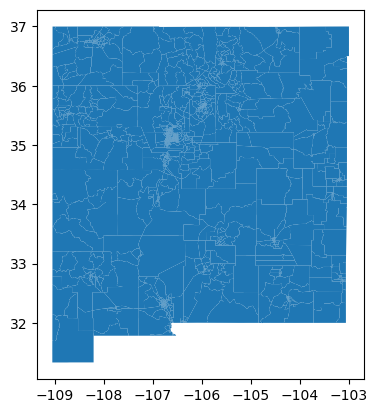

In [105]:
gdf.plot()

In [106]:
gdf_2 = gpd.read_file('/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Data/State Shp Files/NM/s_35.shp')
gdf_2.head()

,ID,DISTRICT,POPULATION,Shape_Leng,Shape_Area,sld_u22,geometry
0,1,1,47068,1.544650,0.043527,35001,"POLYGON ((-108.20971 36.77147, -108.20960 36.7..."
1,2,10,48840,0.711960,0.007563,35010,"POLYGON ((-106.68805 35.13396, -106.68788 35.1..."
2,3,11,50252,0.294066,0.002778,35011,"POLYGON ((-106.76026 35.05588, -106.76061 35.0..."
3,4,12,51681,0.367458,0.003731,35012,"POLYGON ((-106.72010 35.18397, -106.72067 35.1..."
4,5,13,48663,0.549102,0.005031,35013,"POLYGON ((-106.63762 35.04756, -106.63808 35.0..."


<AxesSubplot: >

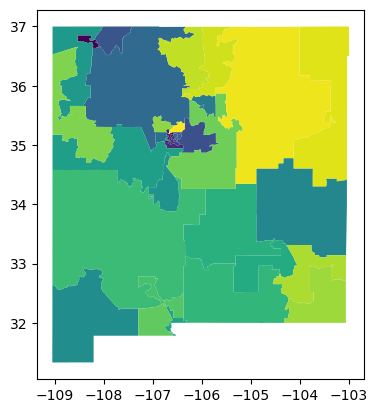

In [107]:
gdf_2.plot(column='ID')

In [124]:
row = gdf_2.loc[0][['ID','geometry']]

In [119]:
new = gpd.GeoDataFrame(columns=['ID','geometry'])

In [127]:
for i in range(1977):
    new.loc[i] = row

In [131]:
gdf[new.contains(gdf)]

/var/folders/25/yq9cvx4n7714ymc6mt488mw80000gn/T/ipykernel_98587/1834881829.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf[new.contains(gdf)]


,block_vtda,state,Shape_Leng,Shape_Area,ID,OID_1,block_vt_1,total,geometry
1538,35045000019,35,0.413441,0.007267,1538,1538,35045000019,806.0,"POLYGON ((-108.20613 36.70594, -108.20601 36.7..."
1540,35045000021,35,0.831866,0.025262,1540,1540,35045000021,1624.0,"POLYGON ((-108.49078 36.85026, -108.48770 36.8..."
1541,35045000022,35,0.169255,0.000724,1541,1541,35045000022,1548.0,"POLYGON ((-108.36729 36.76501, -108.36678 36.7..."
1542,35045000023,35,0.164378,0.000716,1542,1542,35045000023,1422.0,"POLYGON ((-108.40295 36.75319, -108.40231 36.7..."
1544,35045000025,35,0.141084,0.000594,1544,1544,35045000025,1021.0,"POLYGON ((-108.28778 36.73111, -108.28778 36.7..."
1545,35045000026,35,0.149852,0.001194,1545,1545,35045000026,1005.0,"POLYGON ((-108.30338 36.76381, -108.30326 36.7..."
1546,35045000027,35,0.156963,0.000855,1546,1546,35045000027,1989.0,"POLYGON ((-108.28589 36.76360, -108.28444 36.7..."
1547,35045000028,35,0.042916,0.000101,1547,1547,35045000028,1059.0,"POLYGON ((-108.20528 36.74844, -108.20398 36.7..."
1548,35045000029,35,0.042869,0.000080,1548,1548,35045000029,982.0,"POLYGON ((-108.20645 36.74122, -108.20636 36.7..."
1549,35045000030,35,0.054302,0.000145,1549,1549,35045000030,1395.0,"POLYGON ((-108.21226 36.75522, -108.21176 36.7..."


# Restart Chain

In [12]:
def get_next_partition(original_file:str, last_output:str, original_mapping:str, vtd_column:str):

    iterations = pd.read_csv(last_output)
    last_column = str(len(iterations.columns) - 1)
    replace_with = iterations[['Iteration',last_column]]

    original = gpd.read_file(original_file)
    new_frame = original.merge(replace_with,left_on=vtd_column,right_on='Iteration').drop(original_mapping,axis=1).rename(columns={last_column:'District'})

    return new_frame


In [13]:
new_frame = get_next_partition(original_file='/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/Data/State Shp Files/AL/Alabama_VTD_District_Intersection.shp',last_output='/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/test_output',original_mapping='cd_117',vtd_column='VTD')

In [19]:
test_chain.update_partition(new_gdf=new_frame, grouping_assignment_column='District',updaters=test_chain.get_updaters())

/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/rebeccawagner/opt/anaconda3/envs/gerry/lib/python3.10/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column last!
  warnings.wa